## Whole Foods 'ON SALE' and 'PRIME DISCOUNT' Data
### This data is scraped from Whole Foods Featured On Sale Web Page
#### This jupyter notebook cleans, aggregates, and creates new features to show insights of many different details of Whole Foods 'On Sale Items' such as:

    - items with the highest prime discounts
    - items with the highest prime discounts by company
    - difference between sales discounts and prime discounts (Shows how much of a bigger discount prime members receive than normal shoppers)

In [9]:
import os, random, sys, time 
from selenium import webdriver
from bs4 import BeautifulSoup
import pandas as pd
browser = webdriver.Chrome('C:/Users/Water/Desktop/chromedriver.exe') # Chrome Driver
browser.get('https://www.wholefoodsmarket.com/products/all-products?featured=on-sale') # Website Link
browser.find_element_by_xpath("//input[@id='pie-store-finder-modal-search-field']").send_keys('19073') # Zip code
time.sleep(2) # lag for 2 seconds to allow elements to load
browser.find_element_by_xpath("//span[contains(text(),'Newtown - 3737 West Chester Pike, Newtown Square, PA 19073')]").click() # needs optimization

In [10]:
#---------------------
# Continously loads all possible product data until no more data exists
# Sometimes may take some time if there are many products on sale
try:
    load = browser.find_element_by_xpath("//span[contains(text(),'Load more')]") 
    while True:
        load.click()
        time.sleep(2) # Must have a 2 sec time lag so the 'load more' button can reappear
except:
    print("Results Filled") # If all possible data is populated

Results Filled


------------------------

In [11]:
all_items = browser.find_elements_by_xpath("//div[@data-testid='product-tile']") # Pull all product elements by xpath
list_of_items = [items.text.splitlines() for items in all_items] # Create a list comprehension of all product elements with text shown and lines split

In [139]:
#import pickle
#with open('list_of_items.pkl', 'wb') as handle:
#    pickle.dump(list_of_items, handle, protocol=pickle.HIGHEST_PROTOCOL) # Save list_of_items to a .pkl so we dont have to rescrape and load in the future
#
# 
#with open('list_of_items.pkl', 'rb') as handle: # loads our saved .pkl back into a variable
#    test = pickle.load(handle)

True

---------------

In [162]:
d = {"company":[], "product":[], "regular":[], "sale":[], "prime":[]} # Create a Dict

In [163]:
for i in range(len(all_items)):                        # At the range of the length of all items (will loop i times)
        d["company"].append(list_of_items[i][-5])      # Append respective indexed data in list_of_items[i] for each column
        d["product"].append(list_of_items[i][-4])      # | -
        d["regular"].append(list_of_items[i][-3][8:])  # | * 
        d["sale"].append(list_of_items[i][-2][10:])    # | /
        d["prime"].append(list_of_items[i][-1][18:])   # | \
print(len(d["company"]))                               # Verify that the length of each column is == to each other, otherwise the dataframe wont be populated 
print(len(d["product"]))                               # | - 
print(len(d["regular"]))                               # | *
print(len(d["sale"]))                                  # | /
pd.set_option("display.max_rows", 500)                 # | \ Change Pandas option to view more rows of the df
df = pd.DataFrame.from_dict(d)                         # Turn our Dict to a Pandas DataFrame  

2075
2075
2075
2075


In [164]:
# BAKERY is not a product name, WholeFoods sometimes lists the origin as the product name since it is made in house
# Because of this we will grab the indices where this is True and remove all rows that pertain to these indices
# We will then create a new dictionary and re-append all items again with shifted index values to properly fit each KEY and Value (Ex. Bakery goes under Company in this case)
# We will then set this new dict as df2, and reinstantiate df2 as df2 where 'BAKERY' only exists 
# Finally we concat the df where we dropped the rows, and the new df2 that has our new 'BAKERY' rows
if any(list(df['product'].str.contains('BAKERY'))):        
    ix = df[df['product'].str.contains('BAKERY')].index
    df = df.drop(list(ix))
    a = {"company":[], "product":[], "regular":[], "sale":[], "prime":[]}
    for i in range(len(all_items)):                        
        a["company"].append(list_of_items[i][-4])
        a["product"].append(list_of_items[i][-3])
        a["regular"].append(list_of_items[i][-2][8:])
        a["sale"].append(list_of_items[i][-2][8:])
        a["prime"].append(list_of_items[i][-1][19:])
    df2 = pd.DataFrame.from_dict(a)
    df2 = df2[df2['company'].str.contains('BAKERY')]
    df = pd.concat([df,df2]).sort_index()
#-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------    
# We then sort by index and remove all '$' and '/lb' symbols from each column to prepare the data for numerical values
df = df.sort_index()  
df['sale'] = df['sale'].str.replace(r'$', '')
df['prime'] = df['prime'].str.replace(r'$', '')
df['regular'] = df['regular'].str.replace(r'$', '')
df['sale'] = df['sale'].str.rstrip('  /lb')
df['prime'] = df['prime'].str.rstrip('  /lb')
df['regular'] = df['regular'].str.rstrip('  /lb')

C:\Users\water\AppData\Local\Temp/ipykernel_27196/887583663.py:22: FutureWarning:

The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.

C:\Users\water\AppData\Local\Temp/ipykernel_27196/887583663.py:23: FutureWarning:

The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.

C:\Users\water\AppData\Local\Temp/ipykernel_27196/887583663.py:24: FutureWarning:

The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.



----------------------------------

#### Code used for debugging to see values in the 'Company' Column that have the VALID THROUGH caption instead of Company Name

In [852]:
#df[df['company'].str.contains('/')].sort_values(by='product') # Used for Debugging to see values in the 'Company' Column that have the VALID THROUGH Date caption instead of Company Name

#### Sample Code to fetch indicies of rows where a specific str exists in a DataFrame and Loop any potential edits


In [709]:
#if any(list(df['company'].str.contains('/'))):                         
#    ix = df[df['company'].str.contains('/')].index
#    for i in range(len(ix)):
#        df.loc[ix[i],'company'] = df.loc[ix[i], 'product'] 

----------------------------

#### Continued data cleaning of companies and products in the wrong sections since Whole Foods has some products without a company name or without a sale price (ex. Prime Only Discounts)

In [165]:
# Data cleaning/shifting for products by Brita
if any(list(df['company'].str.contains('/'))) and any(list(df['product'].str.contains('Brita'))):
    ix = df[df['company'].str.contains('/')][df['product'].str.contains('Brita')].index
    for i in range(len(ix)):
        df.loc[ix[i], 'company'] = df.loc[ix[i], 'product']
        df.loc[ix[i], 'product'] = list_of_items[ix[i]][-3]
        df.loc[ix[i], 'regular'] = list_of_items[ix[i]][-2][8:]
        df.loc[ix[i], 'sale'] = 0

C:\Users\water\AppData\Local\Temp/ipykernel_27196/1154484415.py:3: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [166]:
# Data cleaning/shifting for products
if any(list(df['product'].str.contains("Easy Peel White Shrimp 8-12 Count"))):
    ix = df[df['product'].str.contains("Easy Peel White Shrimp 8-12 Count")].index
    for i in range(len(ix)):
        df.loc[ix[i],'company'] = "Whole Foods Market"
if any(list(df['product'].str.contains("Organic Freeze Dried Chives, 0.14 oz"))):
    ix = df[df['product'].str.contains("Organic Freeze Dried Chives, 0.14 oz")].index
    for i in range(len(ix)):
        df.loc[ix[i],'company'] = "Green Garden"
if any(list(df['product'].str.contains("Organic Freeze Dried Thyme, 0.26 oz"))):
    ix = df[df['product'].str.contains("Organic Freeze Dried Thyme, 0.26 oz")].index
    for i in range(len(ix)):
        df.loc[ix[i],'company'] = "Green Garden"
if any(list(df['product'].str.contains("Organic Mild Plant Taco Meatless Crumbles"))):
    ix = df[df['product'].str.contains("Organic Mild Plant Taco Meatless Crumbles")].index
    for i in range(len(ix)):
        df.loc[ix[i],'company'] = "PLANT BOSS"
if any(list(df['product'].str.contains("Organic Multicolor Kale"))):
    ix = df[df['product'].str.contains("Organic Multicolor Kale")].index
    for i in range(len(ix)):
        df.loc[ix[i],'company'] = "Whole Foods Market"        

In [167]:
# Data cleaning/shifting for products by Soozy's
if any(list(df['product'].str.contains("Soozy's Birthday Cake Cookies"))):
    ix = df[df['product'].str.contains("Soozy's Birthday Cake Cookies")].index
    for i in range(len(ix)):
        df.loc[ix[i],'company'] = "Soozy's"
if any(list(df['product'].str.contains("Soozys Chocolate Chip Cookies"))):
    ix = df[df['product'].str.contains("Soozys Chocolate Chip Cookies")].index
    for i in range(len(ix)):
        df.loc[ix[i],'company'] = "Soozy's"

In [168]:
# Data cleaning/shifting for products by Whole Foods Market
if any(list(df['product'].str.contains('Whole Foods Market'))):
    ix = df[df['product'].str.contains('Whole Foods Market')].index
    for i in range(len(ix)):
        df.loc[ix[i], 'company'] = df.loc[ix[i], 'product']
        df.loc[ix[i], 'product'] = list_of_items[ix[i]][-3]
        df.loc[ix[i], 'regular'] = list_of_items[ix[i]][-2][8:]
        df['sale'] = df['sale'].str.rstrip('  /lb')
        df['prime'] = df['prime'].str.rstrip('  /lb')
        df['regular'] = df['regular'].str.rstrip('  /lb')
        df.loc[ix[i], 'sale'] = 0

In [169]:
# Data cleaning/shifting for products by CAMELBAK
if any(list(df['product'].str.contains('CAMELBAK'))):
    ix = df[df['product'].str.contains('CAMELBAK')].index
    for i in range(len(ix)):
        df.loc[ix[i], 'company'] = df.loc[ix[i], 'product']
        df.loc[ix[i], 'product'] = list_of_items[ix[i]][-3]
        df.loc[ix[i], 'regular'] = list_of_items[ix[i]][-2][8:]
        df.loc[ix[i], 'sale'] = 0

In [170]:
# Data cleaning/shifting for products by NEW WAVE
if any(list(df['product'].str.contains('NEW WAVE'))):
    ix = df[df['product'].str.contains('NEW WAVE')].index
    for i in range(len(ix)):
        df.loc[ix[i], 'company'] = df.loc[ix[i], 'product']
        df.loc[ix[i], 'product'] = list_of_items[ix[i]][-3]
        df.loc[ix[i], 'regular'] = list_of_items[ix[i]][-2][8:]
        df.loc[ix[i], 'sale'] = 0

In [171]:
# Data cleaning/shifting for products by Enviro
if any(list(df['product'].str.contains('Enviro'))):
    ix = df[df['product'].str.contains('Enviro')].index
    for i in range(len(ix)):
        df.loc[ix[i], 'company'] = df.loc[ix[i], 'product']
        df.loc[ix[i], 'product'] = list_of_items[ix[i]][-3]
        df.loc[ix[i], 'regular'] = list_of_items[ix[i]][-2][8:]
        df.loc[ix[i], 'sale'] = 0

In [172]:
# Data cleaning/shifting for products by HYDRO FLASK
if any(list(df['product'].str.contains('HYDRO FLASK'))):
    ix = df[df['product'].str.contains('HYDRO FLASK')].index
    for i in range(len(ix)):
        df.loc[ix[i],'company'] = df.loc[ix[i], 'product']
        df.loc[ix[i],'product'] = list_of_items[ix[i]][-3]
        df.loc[ix[i], 'regular'] = list_of_items[ix[i]][-2][8:]
        df.loc[ix[i], 'sale'] = 0

In [173]:
# Data cleaning/shifting for products by SUNDESA
if any(list(df['product'].str.contains('SUNDESA'))):
    ix = df[df['product'].str.contains('SUNDESA')].index
    for i in range(len(ix)):
        df.loc[ix[i],'company'] = df.loc[ix[i], 'product']
        df.loc[ix[i],'product'] = df.loc[ix[i], 'regular']
        df.loc[ix[i], 'regular'] = list_of_items[ix[i]][-2][8:]
        df.loc[ix[i], 'sale'] = 0

In [174]:
if any(list(df['product'].str.contains('Lemonade Electrolyte Powder Packet, 0.12 oz'))):
    ix = df[df['product'].str.contains('Lemonade Electrolyte Powder Packet, 0.12 oz')].index
    for i in range(len(ix)):
        df.loc[ix[i], 'regular'] = list_of_items[ix[i]][-3][7:]
if any(list(df['product'].str.contains('Wild Raspberry Electrolyte Powder Packet, 0.11 oz'))):
    ix = df[df['product'].str.contains('Wild Raspberry Electrolyte Powder Packet, 0.11 oz')].index
    for i in range(len(ix)):
        df.loc[ix[i], 'regular'] = list_of_items[ix[i]][-3][7:]
if any(list(df['product'].str.contains('Orange Pkt, 0.3 oz'))):
    ix = df[df['product'].str.contains('Orange Pkt, 0.3 oz')].index
    for i in range(len(ix)):
        df.loc[ix[i], 'regular'] = list_of_items[ix[i]][-3][7:]

In [175]:
d = df.to_dict('list') # Take our cleaned dataframe and convert it to a dictionary for more cleaning

#### The following code replaces strings such as '2 for 5', splits them '2' 'for' '5', and divides position[2] by position[0] '5'/'2' while casting them as float values
#### this way we can understand the unit price per item for such deals, in this example '2 for 5' is 2.50

In [176]:
for i in range(len(d['sale'])):                                                
    if isinstance(d['sale'][i], str) and 'for' in d['sale'][i].split():  
        d['sale'][i] = float(d['sale'][i].split()[2]) / float(d['sale'][i].split()[0])

In [177]:
for i in range(len(d['prime'])):                                                
        if isinstance(d['prime'][i], str) and 'for' in d['prime'][i].split():  
            d['prime'][i] = float(d['prime'][i].split()[2]) / float(d['prime'][i].split()[0])

In [178]:
df = pd.DataFrame.from_dict(d) # turn our dict back into a dataframe


In [201]:
df.to_csv('testing.csv')

In [61]:
df = df.fillna(0) # Sometimes NaN Values are created in Sale Price since there is no Sale Price, We also instantiate 0's here originally when there are no Sale Prices
                  # Some aggregate functions create NaN's again, so we replace them again with 0
df.isna().any()   # We check to see if there are any NaN values

company    False
product    False
regular    False
sale       False
prime      False
dtype: bool

-----------------

In [183]:
for i in range(len(df[df['sale'].str.contains('¢', na=False)].index)): # Append a '.' to all values that have a cents symbol
    ix = df[df['sale'].str.contains('¢', na=False)].index
    df.loc[ix[i]][3] = '.' + df.loc[ix[i]][3]

In [184]:
for i in range(len(ix)):
    ix = df[df['prime'].str.contains('¢', na=False)].index
    df.loc[ix[i]][4] = '.' + df.loc[ix[i]][4]

In [185]:
try:
    for i in range(len(ix)):
        ix = df[df['regular'].str.contains('¢', na=False)].index
        df.loc[ix[i]][2] = '.' + df.loc[ix[i]][2]
except:
    pass

In [198]:
ix = df[df['prime'].str.contains('¢', na=False)].index
for i in range(len(ix)):
    df.loc[ix[i]][4] = df.loc[ix[i]][4].replace('¢', '')

ix = df[df['regular'].str.contains('¢', na=False)].index
for i in range(len(ix)):
    df.loc[ix[i]][2] = df.loc[ix[i]][2].replace('¢', '')

ix = df[df['sale'].str.contains('¢', na=False)].index
for i in range(len(ix)):
    df.loc[ix[i]][3] = df.loc[ix[i]][3].replace('¢', '')


In [147]:
df['sale']=df['sale'].str.rstrip('¢') # Strip the cents symbol afterwords
df['prime']=df['prime'].str.rstrip('¢')
df['regular']=df['regular'].str.rstrip('¢')


In [202]:
df["regular"] = pd.to_numeric(df["regular"]) # change columns to numeric for visualization
df["sale"] = pd.to_numeric(df["sale"])
df["prime"] = pd.to_numeric(df["prime"])

In [203]:
df['sale_discount'] = 1-df['sale']/df['regular'] # create new feature to show percentage discount of sale price
df['prime_discount'] = 1-df['prime']/df['regular'] # create new feature to show percentage discount of prime price

In [204]:
df['prime_sale_difference'] = df['prime_discount'] - df['sale_discount'] # create new feature to show the difference between sale discount and prime discount

In [291]:
df['discount_bins'] = pd.cut(df.prime_discount, [0,.25,.50,.75, 1], labels=['0% to 25%', '25% to 50%', '50% to 75%', '75% or more'])

In [295]:
df = df.sort_values(by='prime_discount', ascending=False) # sort by difference

In [ ]:
df.head(500) # check

In [297]:
df.to_csv('WholeFoods_Bakery_Data_Cleaned.CSV')

In [292]:
df

,company,product,regular,sale,prime,sale_discount,prime_discount,prime_sale_difference,discount_bins
10,Beyond Meat,Beyond Beef Plant-based Ground Beef,8.99,8.79,7.91,0.022247,0.120133,0.097887,0% to 25%
1843,AURA CACIA,"Vetiver Essential Oil, 0.5 fl oz",19.99,19.49,17.54,0.025013,0.122561,0.097549,0% to 25%
454,Lakewood,"PURE Prune Organic, 32 fl oz",7.69,7.49,6.74,0.026008,0.123537,0.097529,0% to 25%
270,Lakewood,"Pure Tart Cherry Juice, 32 fl oz",7.69,7.49,6.74,0.026008,0.123537,0.097529,0% to 25%
1140,HENRY & LISAS,"Wild Sardines In Spring Water, 4.25 oz",3.49,3.39,3.05,0.028653,0.126074,0.097421,0% to 25%
...,...,...,...,...,...,...,...,...,...
993,HYDRO FLASK,Black 32 Oz Wide Mouth Bottle With Flex Cap,44.95,0.00,31.46,1.000000,0.300111,-0.699889,25% to 50%
2055,HYDRO FLASK,40 Oz Wide Mouth With Flex Cap White 2.0,49.95,0.00,34.96,1.000000,0.300100,-0.699900,25% to 50%
1876,Brita,Filter Cartridge Replacement 3Pk,29.99,0.00,20.99,1.000000,0.300100,-0.699900,25% to 50%
1904,Brita,"Marina Filtering Bottle, 32 oz",39.99,0.00,27.99,1.000000,0.300075,-0.699925,25% to 50%


---------------------------

## Exploratory Data Analysis: <br/>
#### Histogram of all numerical feature distributions
##### we can see that 'prime_sale_difference' has a large outlier since we have sale price set to 0 for some items that don't have a sale price


array([[<AxesSubplot:title={'center':'regular'}>,
        <AxesSubplot:title={'center':'sale'}>],
       [<AxesSubplot:title={'center':'prime'}>,
        <AxesSubplot:title={'center':'sale_discount'}>],
       [<AxesSubplot:title={'center':'prime_discount'}>,
        <AxesSubplot:title={'center':'prime_sale_difference'}>]],
      dtype=object)

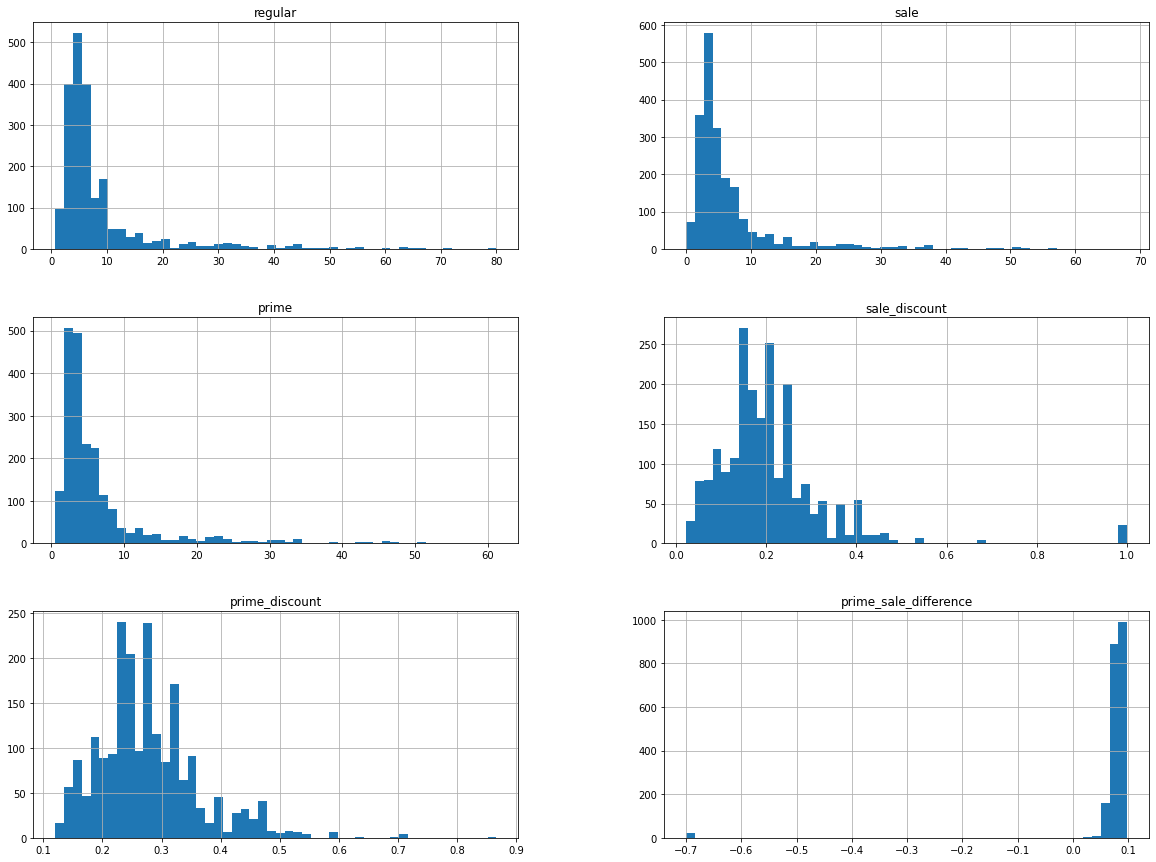

In [207]:
df.hist(bins=50, figsize=(20,15)) 

### These are distributions of all items that do not have a sale price listed
#### We can see that there are not that many items that don't have a sale price
##### Not having a sale price is defined as only having a 'regular price' and 'prime price'
##### These distributions show the items are ONLY discounted for prime members
      - only 23 out of 2075 products which is not many (1%)
      - this shows that over 99% of items on sale are discounted for regular customers and prime customers

In [247]:
len(df[df['prime_sale_difference'] < 0]) 

23

array([[<AxesSubplot:title={'center':'regular'}>,
        <AxesSubplot:title={'center':'sale'}>],
       [<AxesSubplot:title={'center':'prime'}>,
        <AxesSubplot:title={'center':'sale_discount'}>],
       [<AxesSubplot:title={'center':'prime_discount'}>,
        <AxesSubplot:title={'center':'prime_sale_difference'}>]],
      dtype=object)

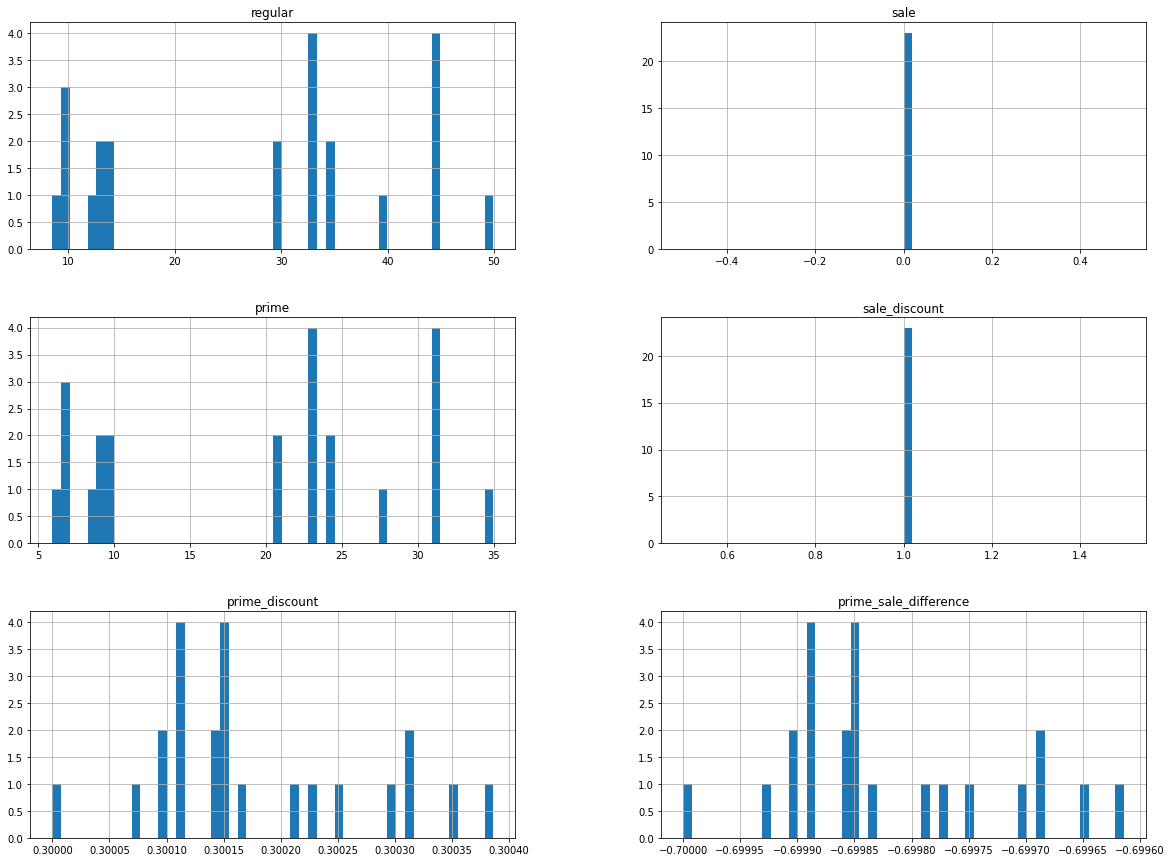

In [222]:
df[df['prime_sale_difference'] < 0].sort_values(by='prime_discount',ascending=False).hist(bins=50, figsize=(20,15)) 

### Histogram with all distributions where 'prime_sale_difference' is > 0 (Products on sale for regular customers and prime members (99% of the data)):
#### Showing all the items with a Regular, Sale, and Prime price
##### We can see that Prime members get an average discount of 28% off of on sale items, while non-members get an average of 20% off on sale items
##### This shows that on average, Prime members get their products discounted by 8% more that regular customers on average!

In [246]:
df[df['prime_sale_difference'] > 0].sort_values(by='prime_discount',ascending=False).describe().loc[['mean']]

,regular,sale,prime,sale_discount,prime_discount,prime_sale_difference
mean,8.215015,6.683366,6.014254,0.196992,0.277425,0.080433


array([[<AxesSubplot:title={'center':'regular'}>,
        <AxesSubplot:title={'center':'sale'}>],
       [<AxesSubplot:title={'center':'prime'}>,
        <AxesSubplot:title={'center':'sale_discount'}>],
       [<AxesSubplot:title={'center':'prime_discount'}>,
        <AxesSubplot:title={'center':'prime_sale_difference'}>]],
      dtype=object)

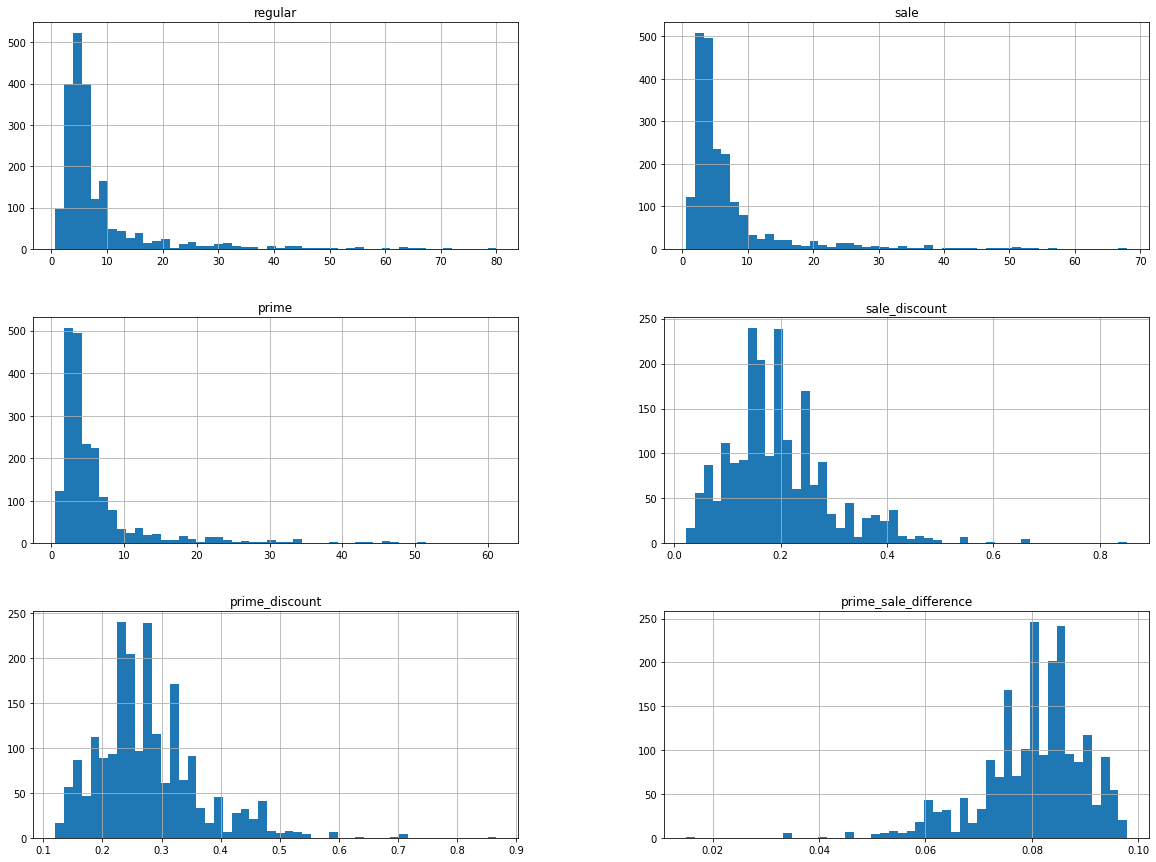

In [224]:
df[df['prime_sale_difference'] > 0].sort_values(by='prime_discount',ascending=False).hist(bins=50, figsize=(20,15)) 

## We can tell that most items that are featured on sale whether that be for non-prime members or prime members, are under $10
### Adding a legend of multiple companies is used for interactivity
#### If you know a favorite company of yours that sells a product at Whole Foods, try double clicking on them to see whether they have items on sale that meet your discounted needs!

In [280]:
import matplotlib as plt
import plotly.express as px
import plotly.graph_objects as go

fig = px.scatter(df.sort_values(by='company'), x="prime_discount", y="regular", color="company", title="Products: Regular Price vs Prime Discount by Company", hover_data=['product', 'sale', 'prime'], width=1400, height=1000,
labels={
    "regular": "Regular Prices of Products",
    "prime_discount": "Prime Discount by Percent"
})
fig.show()

In [300]:
fig = px.scatter(df.sort_values(by='discount_bins'), x="prime_discount", y="regular", color="discount_bins", title="Products: Regular Price vs Prime Discount by Prime Discount Range", hover_data=['product', 'sale', 'prime'], width=1400, height=1000,
labels={
    "regular": "Regular Prices of Products",
    "prime_discount": "Prime Discount by Percent",
    "discount_bins": "Prime Discount Ranges"
})
fig.show()

In [301]:
df

,company,product,regular,sale,prime,sale_discount,prime_discount,prime_sale_difference,discount_bins
1188,Simply Organic,"Organic Ground Black Pepper, 4 oz",5.99,0.89,0.80,0.851419,0.866444,0.015025,75% or more
1770,Brekki,"Banana And Maple Brown Sugar Overnight Oats, 5...",2.99,0.99,0.89,0.668896,0.702341,0.033445,50% to 75%
1778,Brekki,Overnight Oats With Ancient Grains Buleberries...,2.99,0.99,0.89,0.668896,0.702341,0.033445,50% to 75%
1690,Brekki,"Original Overnight Oats, 5.3 oz",2.99,0.99,0.89,0.668896,0.702341,0.033445,50% to 75%
1938,Brekki,"Strawberry Overnight Oats, 5.3 oz",2.99,0.99,0.89,0.668896,0.702341,0.033445,50% to 75%
...,...,...,...,...,...,...,...,...,...
1081,Navitas Organics,"Organic Hemp Seeds, 8 Oz",10.79,10.49,9.44,0.027804,0.125116,0.097312,0% to 25%
270,Lakewood,"Pure Tart Cherry Juice, 32 fl oz",7.69,7.49,6.74,0.026008,0.123537,0.097529,0% to 25%
454,Lakewood,"PURE Prune Organic, 32 fl oz",7.69,7.49,6.74,0.026008,0.123537,0.097529,0% to 25%
1843,AURA CACIA,"Vetiver Essential Oil, 0.5 fl oz",19.99,19.49,17.54,0.025013,0.122561,0.097549,0% to 25%
